In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC

In [4]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC

In [2]:
merged_df = pd.read_csv('protein_expression.csv')
inputed_columns = ['AGID00215',
 'AGID00537',
 'AGID00536',
 'AGID00211',
 'AGID00485',
 'AGID00383',
 'AGID00216',
 'AGID00257',
 'AGID00545',
 'AGID00413',
 'AGID00547',
 'AGID00144']

In [5]:
protein_columns = merged_df.columns.drop(["ajcc_pathologic_stage","vital_status","days_to_death","days_to_last_follow_up","case_submitter_id"])
protein_columns

Index(['AGID00100', 'AGID00111', 'AGID00101', 'AGID00001', 'AGID00002',
       'AGID00003', 'AGID00443', 'AGID00120', 'AGID00004', 'AGID00005',
       ...
       'AGID00349', 'AGID02137', 'AGID00088', 'AGID00089', 'AGID00504',
       'AGID00095', 'AGID02217', 'AGID02210', 'AGID00326', 'AGID00432'],
      dtype='object', length=468)

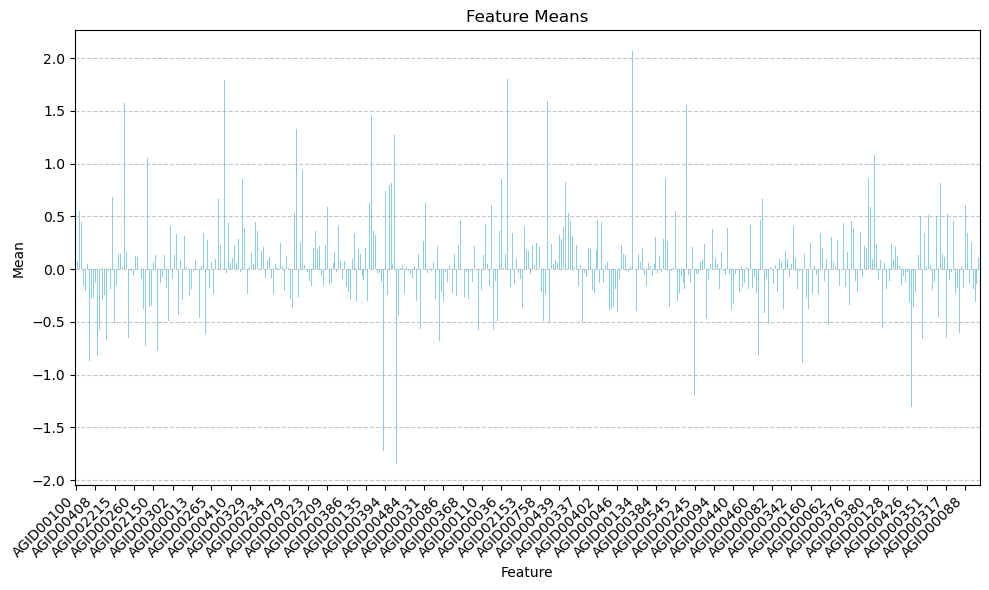

In [6]:
describe_df = merged_df[protein_columns].describe()
row_means = describe_df.loc['mean']

# Plot row means
plt.figure(figsize=(10, 6))
row_means.plot(kind='bar', color='skyblue')
plt.title('Feature Means')
plt.xlabel('Feature')
plt.ylabel('Mean')

plt.xticks(range(0, len(row_means), 10), row_means.index[::10], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()

In [7]:
merged_df = merged_df.drop(["ajcc_pathologic_stage","vital_status","days_to_last_follow_up","case_submitter_id"], axis=1)
other = merged_df.columns.drop("days_to_death")

scaler = MinMaxScaler()
merged_df[other] = scaler.fit_transform(merged_df[other])

X_train, X_test, y_train, y_test = train_test_split(merged_df[other], merged_df["days_to_death"],
                                                    train_size=0.75,
                                                    random_state=1)

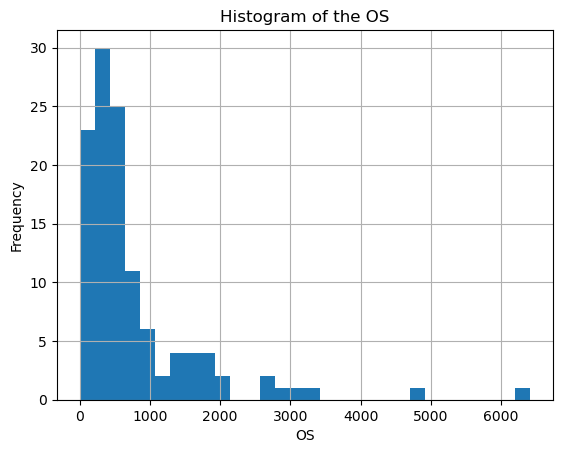

In [8]:
y_train.hist(bins=30) 
plt.xlabel('OS')
plt.ylabel('Frequency')
plt.title('Histogram of the OS')
plt.show()

In [ ]:
class AE():
    def __init__(self,X_train,X_test,y_train,y_test,bottleneck,type):
        self.X_train = X_train
        self.X_test = X_test        
        self.y_train = y_train
        self.y_test = y_test
        self.bottleneck = bottleneck
        self.history = None
        self.encoder = None
        self.autoencoder = None
        self.type = type
        self.classifer = None

    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(64, activation='relu')(input_layer)
        encoder = Dense(32, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(32, activation='relu')(bottleneck)
        decoder = Dense(64, activation='relu')(decoder)
        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        self.history = self.autoencoder.fit(self.X_train, self.X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(self.X_test, self.X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()

    def plot(self):
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss '+ self.type)
        plt.legend()
        plt.show()

    def encode(self):
        self.autoencoder.load_weights(f'model/{self.type}_best_model.keras')
        self.encoded_X_train = self.encoder.predict(self.X_train)
        self.encoded_X_test = self.encoder.predict(self.X_test)
    
    def do_PCA(self,n_components):
        if self.bottleneck == 2:
            # pca = PCA(n_components=n_components)
            # reduced_data = pca.fit_transform(self.encoded_X_test)
            x = self.encoded_X_test[:, 0]
            y = self.encoded_X_test[:, 1]
            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(x, y, c=self.y_test_in_bin, cmap='viridis', alpha=0.7)
            plt.title('Encoded Data '+self.type)
            plt.xlabel('Encoded Dim 0')
            plt.ylabel('Encoded Dim 1')
            plt.colorbar(scatter, label='OS')
            plt.grid(True)
            plt.show()
            return
        if n_components ==2:
            pca = PCA(n_components=n_components)
            reduced_data = pca.fit_transform(self.encoded_X_test)
            x = reduced_data[:, 0]
            y = reduced_data[:, 1]
            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(x, y, c=self.y_test_in_bin, cmap='viridis', alpha=0.7)
            plt.title('PCA of Encoded Data '+self.type)
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.colorbar(scatter, label='OS')
            plt.grid(True)
            plt.show()
        elif n_components ==3:
            pca = PCA(n_components=3)  # Reduce to 3 dimensions
            reduced_data = pca.fit_transform(self.encoded_X_test)
            x = reduced_data[:, 0]
            y = reduced_data[:, 1]
            z = reduced_data[:, 2]
            fig =plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(x, y, z, c=self.y_test_in_bin, cmap='viridis', depthshade=True)
            ax.set_title('3D PCA of Encoded Data '+self.type)
            ax.set_xlabel('Principal Component 1')
            ax.set_ylabel('Principal Component 2')
            ax.set_zlabel('Principal Component 3')
            plt.colorbar(scatter, label='OS')
            plt.show()

    @staticmethod
    def map_years_to_group(value):
        years = value / 365
        if years <= 1:
            return 0
        elif 1 < years <= 3:
            return 1
        elif 3 < years <= 5:
            return 2
        elif 5 < years <= 10:
            return 3
        elif 10 < years <= 20:
            return 4
        else:  
            return 5
        
    @staticmethod        
    def map_to_binary(category):
        if category >= 4:
            return 1
        else:  
            return 0
        
    def map_y(self):
        self.y_trian_in_category = self.y_train.map(AE.map_years_to_group)
        self.y_test_in_category = self.y_test.map(AE.map_years_to_group)        
        
        self.y_trian_in_bin = self.y_trian_in_category.map(AE.map_to_binary)
        self.y_test_in_bin = self.y_test_in_category.map(AE.map_to_binary)

    def do_RF(self,binary,plot=False):
        clf = RandomForestClassifier(n_estimators=100, random_state=0)

        if binary:
            clf.fit(self.encoded_X_train, self.y_trian_in_bin)
            y_pred = clf.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_bin, y_pred)
            print(classification_report(self.y_test_in_bin, y_pred))

        else:
            clf.fit(self.encoded_X_train, self.y_trian_in_category)
            y_pred = clf.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_category, y_pred)
            print(classification_report(self.y_test_in_category, y_pred))

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_bin))
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('RF Confusion Matrix '+self.type)
        plt.show()
        self.classifer = clf

    def do_Kmean(self):
        # Number of clusters - assuming you want as many as your known classes
        num_clusters = 2
        # Perform K-means clustering on the PCA output
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
        cluster_labels = kmeans.fit_predict(self.encoded_X_test)  # Use your 2D or 3D PCA-reduced data here


        print("Classification Report:")
        print(classification_report(self.y_test_in_bin, cluster_labels))
        conf_mat = confusion_matrix(self.y_test_in_bin, cluster_labels)

        # Plotting the confusion matrix
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_clusters), yticklabels=np.unique(self.y_test_in_bin))
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('K-mean Confusion Matrix '+self.type)
        plt.show()
        self.classifer = kmeans

    def do_SVM(self,binary):
        svm_classifier = SVC(kernel='linear',random_state=0)
        # Load the best weights into the autoencoder model
        if binary:
            svm_classifier.fit(self.encoded_X_train, self.y_trian_in_bin)
            y_pred = svm_classifier.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_bin, y_pred)
            print(classification_report(self.y_test_in_bin, y_pred))
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_bin))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('SVM Confusion Matrix '+ self.type)
            plt.show()
        else:
            svm_classifier.fit(self.encoded_X_train, self.y_trian_in_category)
            y_pred = svm_classifier.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_category, y_pred)
            print(classification_report(self.y_test_in_category, y_pred))
        
            # Plotting the confusion matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_category))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('SVM Confusion Matrix '+ self.type)
            plt.show()
        self.classifer = svm_classifier


        


# Resources Investigation:

ICGC:
https://dcc.icgc.org/repositories?filters=%7B%22file%22:%7B%20%22projectCode%22:%7B%22is%22:%5B%22HNSC-US%22%5D%7D%7D%7D

 Data Type
 SSM  2,126
 Aligned Reads  2,037
 Clinical Data  453
 Biospecimen Data  448
 StSM  223
 SGV  132
 CNSM  88
 StGV  88

TCPA:
https://www.tcpaportal.org/tcpa/download.html

TCGA of 2018, with L4(normalized across RPPA batches therefore enable pan-cancer)

PDC:
https://proteomic.datacommons.cancer.gov/pdc/browse
3 studies, but Mass Spectrum not RPPA, therefore only contains Peptide result. do have clinincal though

HNSCC PDX: 
https://aacrjournals.org/mcr/article/14/3/278/89624/Proteomic-Characterization-of-Head-and-Neck-Cancer
RPPA, but on mention how to acess and probabaly wound not have clinical since the read from transplated rats.

HAP: Reference RNA and protein from healthy samples:
https://www.proteinatlas.org/about/download

Pride:Full MS sets
https://www.ebi.ac.uk/pride/archive?keyword=HNSCC,RPPA&sortDirection=DESC&page=0&pageSize=20

Paper HNSCC: RPPA but only target 60 specific protein
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3070553/

GEO: Some Protein profiling by protein array (RPPA), no HNSCC
https://www.ncbi.nlm.nih.gov/geo/browse/

ArraryExpress: RPPA for GBM, lung cancer, breast cancer
https://www.ebi.ac.uk/biostudies/arrayexpress/studies?query=RPPA

FANTOM6 Experiment Index: RNA-Seq
https://fantom.gsc.riken.jp/6/experiment_index/#/

Resources index: 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6971871/